For each section, first plot is 201812, second plot is 201905 and third plot is 201905-201812

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Set-up

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]
print (deptht.shape)

(40,)


## Month

In [114]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov'] #'may'
imonth = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'] #'05'
allmonths = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [115]:
year = ['2015']

# Functions

In [116]:
def surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2, twoD=False):
    fig, axs = plt.subplots(3, 13, figsize=(18, 12))

    for im, month in enumerate(allmonths):
        if month in imonth:
            ym = year[0] + month
            ds = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_1m_'
                                     +ym+'_'+ym+'_'+file+'_T.nc')
            if twoD:
                field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
            else:
                field = np.ma.array(ds[tracer][0, 0], mask=1-tmask[0,0])
                
            colours0 = axs[0, im].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
            axs[0, im].set_title(months[im])
        
            if file == 'turb':
                file2 = 'carp'
            else:
                file2 = file      
            dn = xr.open_dataset('/results/SalishSea/averages/hindcast.201905/SalishSea_1m_'+
                                     ym+'_'+ym+'_'+file2+'_T.nc')

            if twoD:
                field2 = np.ma.array(dn[tracer][0], mask=1-tmask[0,0])
            else:
                field2 = np.ma.array(dn[tracer][0, 0], mask=1-tmask[0,0])
                
            colours = axs[1, im].pcolormesh(field2, cmap=cmap, vmax=vmax, vmin=vmin)
           
            colours = axs[2, im].pcolormesh(field2-field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
            ds.close()
            dn.close()
    cbar = fig.colorbar(colours0, ax=axs[0:1+1, -1],extend='both',
                shrink=0.5)
    cbar.set_label(cb1)
    cbar = fig.colorbar(colours, ax=axs[2, -1], extend='both',
                )
    cbar.set_label(cb2)
    for ax in axs[0]:
        ax.axis('off')
        viz_tools.set_aspect(ax)
    for ax in axs[1]:
        ax.axis('off')
        viz_tools.set_aspect(ax)
    for ax in axs[2]:
        ax.axis('off')
        viz_tools.set_aspect(ax)
            
   
    return fig

In [117]:
def profiles(tracer, file):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    
    if file == 'turb':
        file2 = 'carp'
    else:
        file2 = file
        
    for im, month in enumerate(allmonths):
        if month in imonth:
            ym = year[0] + month
          
            ds = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_1m_'
                                     +ym+'_'+ym+'_'+file+'_T.nc')
    
            field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
            axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label=months[im])
            
            dn = xr.open_dataset('/results/SalishSea/averages/hindcast.201905/SalishSea_1m_'+
                                     ym+'_'+ym+'_'+file2+'_T.nc')
            field2 = np.ma.array(dn[tracer][0], mask=1-tmask[0])
            axs[1].plot(field2.mean(axis=1).mean(axis=1), deptht, label=months[im])
            axs[2].plot((field2-field).mean(axis=1).mean(axis=1), deptht, label=months[im])
            ds.close()
            dn.close()

    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    axs[2].invert_yaxis()
    axs[2].legend(loc='best')
    return fig

In [118]:
def thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax):
 
    fig, axs = plt.subplots(13, 3, figsize=(20, 30))
    
        
    if file == 'turb':
        file2 = 'carp'
    else:
        file2 = file

    
    for im, month in enumerate(allmonths):
        if month in imonth:
            ym = year[0] + month
            ds = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_1m_'
                                     +ym+'_'+ym+'_'+file+'_T.nc')
            field = np.array(ds[tracer][0])
            cbar = vis.contour_thalweg(axs[im, 0], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, 
                                        (vmax-vmin)/10.), cmap=cmap, cbar_args={'orientation': 'horizontal'})
            cbar.remove()
            axs[im, 0].set_title(months[im])

            dn = xr.open_dataset('/results/SalishSea/averages/hindcast.201905/SalishSea_1m_'+
                                     ym+'_'+ym+'_'+file2+'_T.nc')
            field2 = np.array(dn[tracer][0])
            cbar = vis.contour_thalweg(axs[im, 1], field2, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, 
                                        (vmax-vmin)/10.), cmap=cmap, cbar_args={'orientation': 'horizontal'})
            cbar.remove()
            cbar = vis.contour_thalweg(axs[im, 2], field2-field, bathy, mesh, 
                                          np.arange(-dvmax, 1.2*dvmax, dvmax/5), cmap=cdiff, cbar_args={'orientation': 'horizontal'})
            cbar.remove()

            ds.close()
            dn.close()
    for ax in axs[:, 0]:
        ax.axis('off')
    for ax in axs[:, 1]:
        ax.axis('off')
    for ax in axs[:, 2]:
        ax.axis('off')
    
    return fig

# Surface Plots

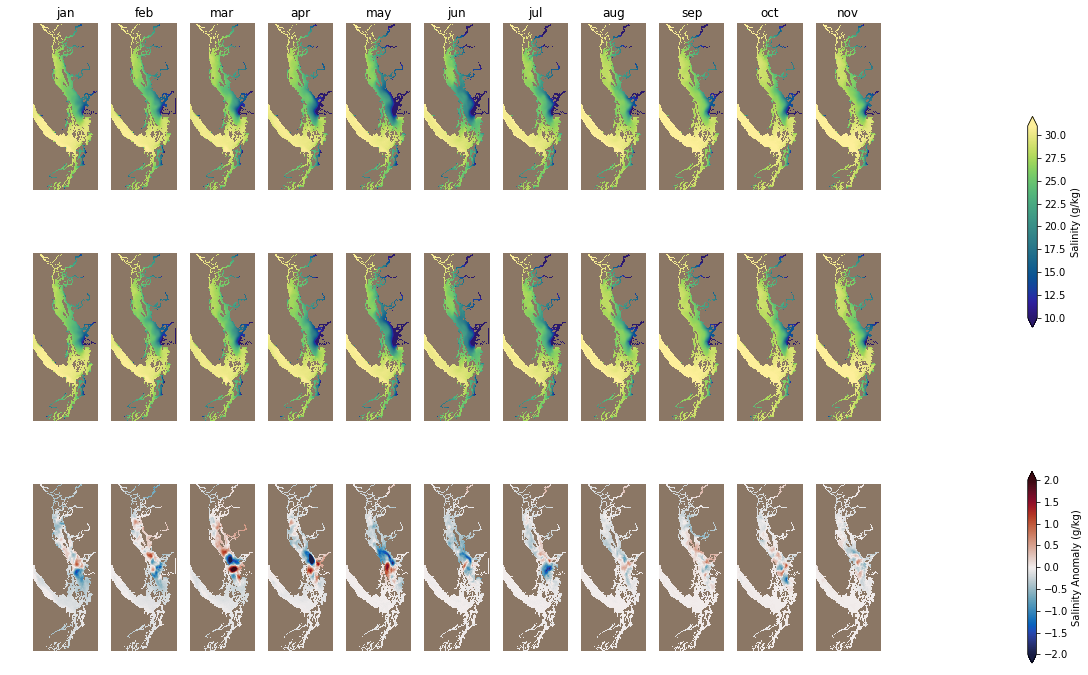

In [119]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cmap.set_bad('#8b7765')
cb1 = 'Salinity (g/kg)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Salinity Anomaly (g/kg)'
vmax = 31
vmin = 10
dvmax = 2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

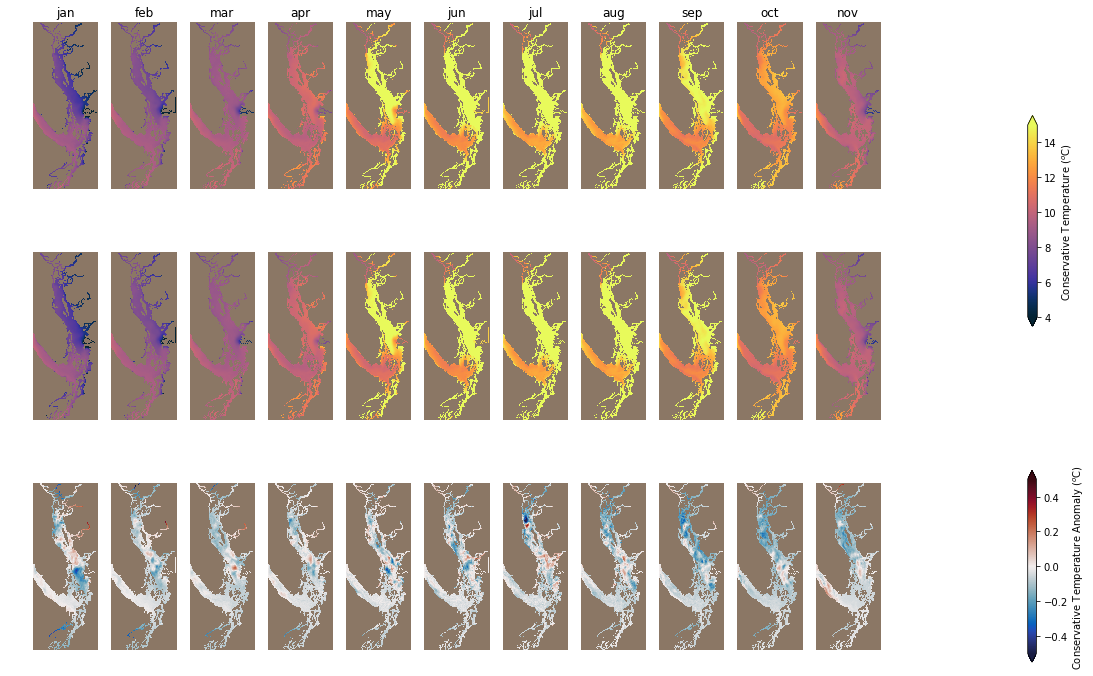

In [120]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cmap.set_bad('#8b7765')
cb1 = 'Conservative Temperature ($^o$C)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Conservative Temperature Anomaly ($^o$C)'
vmax = 15
vmin = 4
dvmax = 0.5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

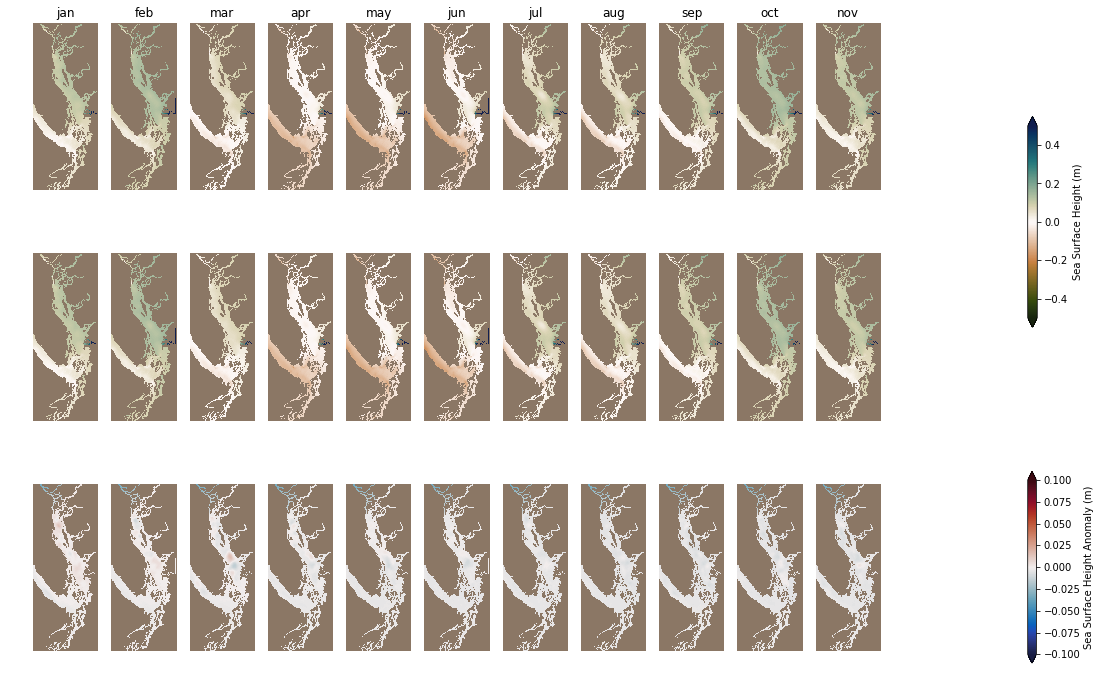

In [121]:
tracer = 'sossheig'
file = 'grid'
cmap = cm.tarn
cmap.set_bad('#8b7765')
cb1 = 'Sea Surface Height (m)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Sea Surface Height Anomaly (m)'
vmax = 0.5
vmin = -0.5
dvmax = 0.1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2, twoD=True)
fig.savefig(tracer+'_compare_2015_surface.png')

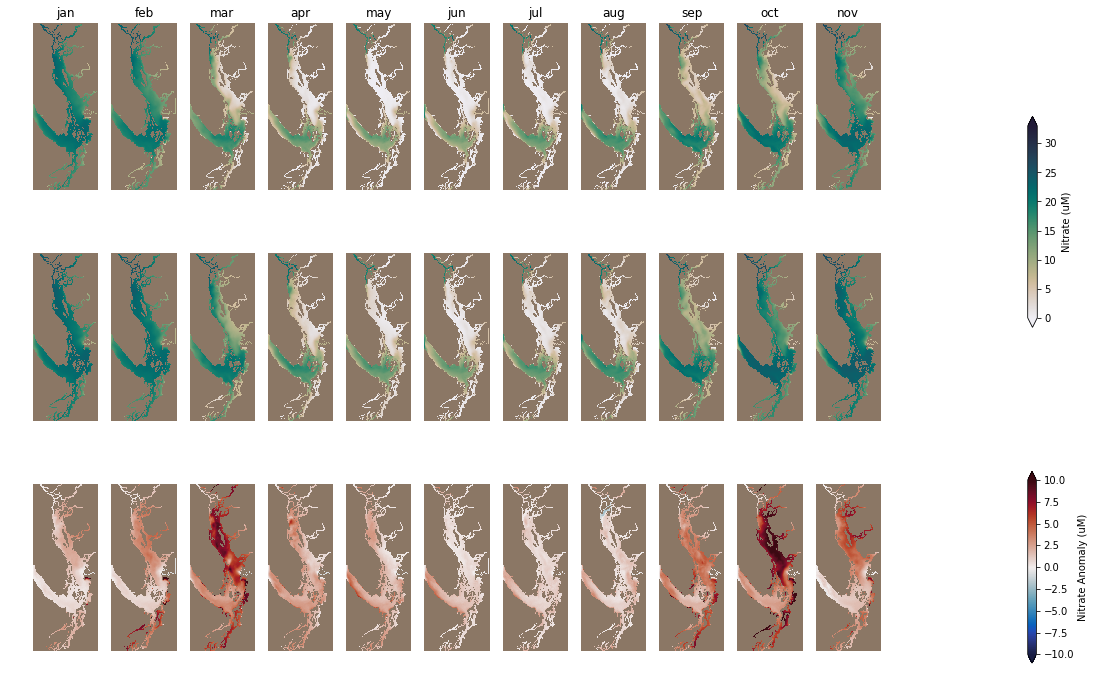

In [122]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cmap.set_bad('#8b7765')
cb1 = 'Nitrate (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Nitrate Anomaly (uM)'
vmax = 33
vmin = 0
dvmax = 10
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

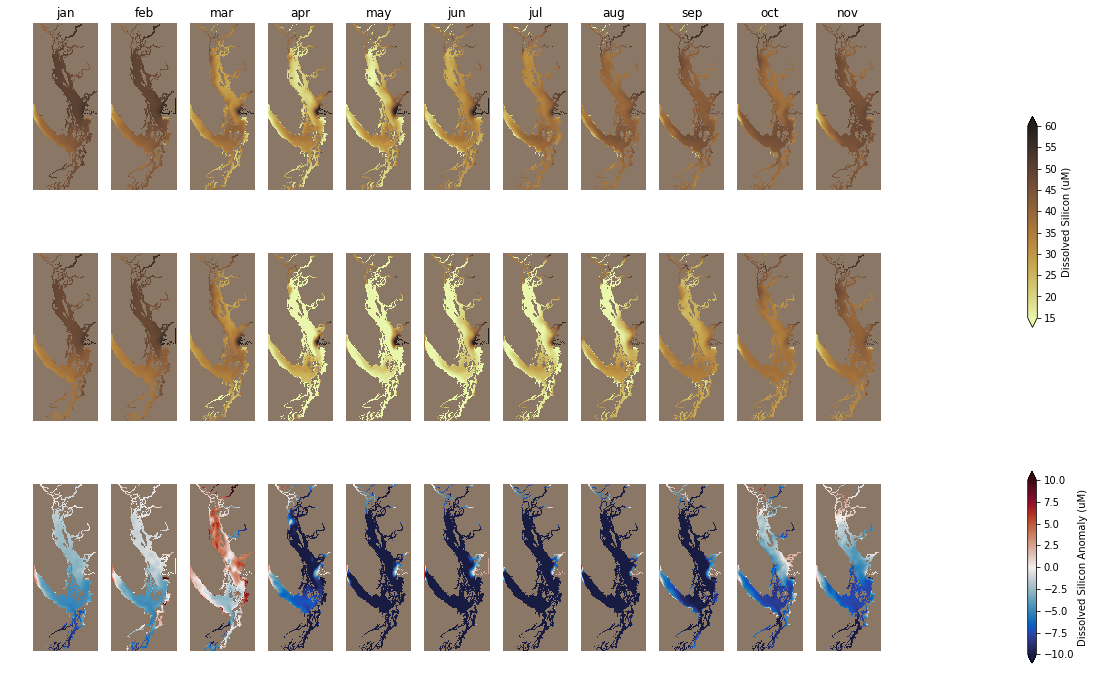

In [123]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cmap.set_bad('#8b7765')
cb1 = 'Dissolved Silicon (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Dissolved Silicon Anomaly (uM)'
vmax = 60
vmin = 15
dvmax = 10
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

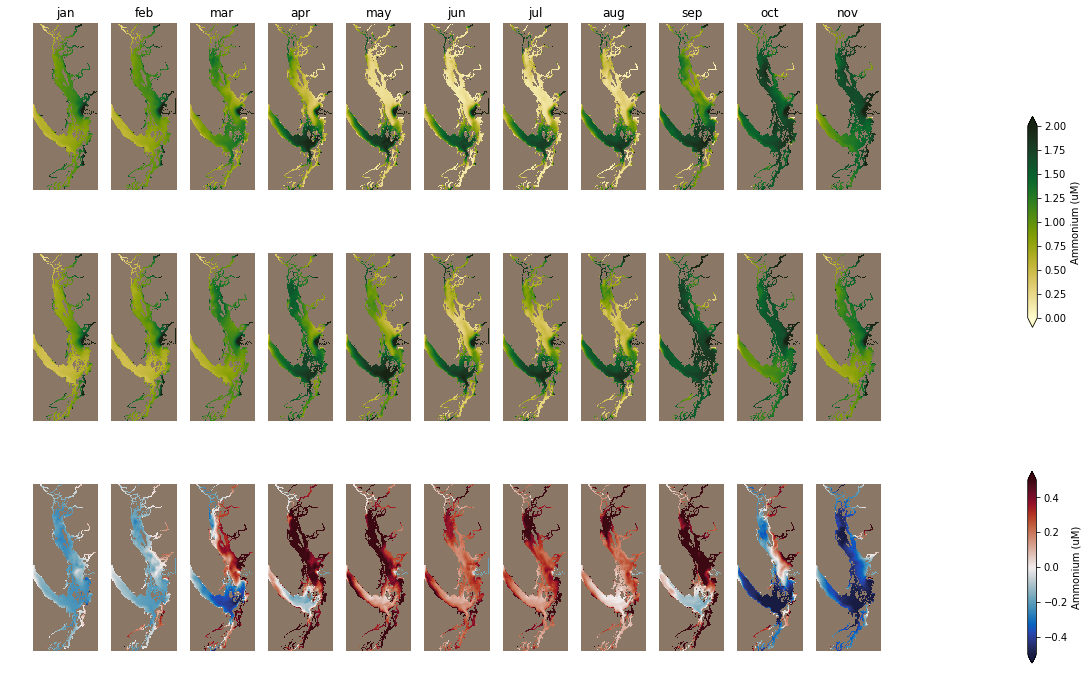

In [124]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cmap.set_bad('#8b7765')
cb1 = 'Ammonium (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Ammonium (uM)'
vmax = 2
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

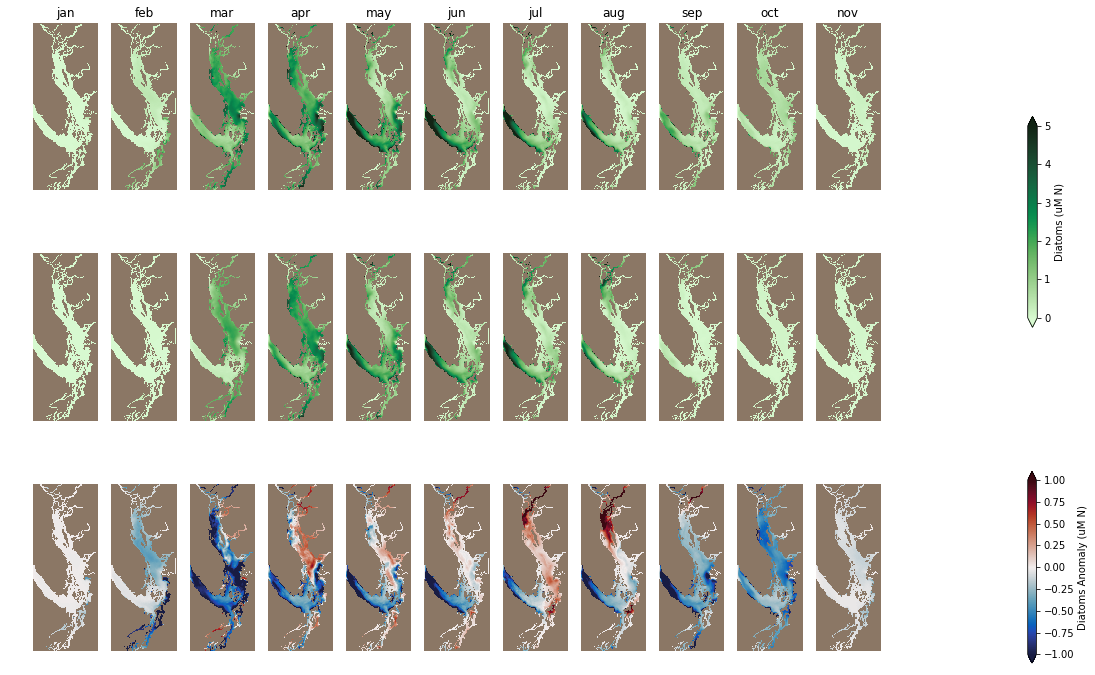

In [125]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cmap.set_bad('#8b7765')
cb1 = 'Diatoms (uM N)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = "Diatoms Anomaly (uM N)"
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

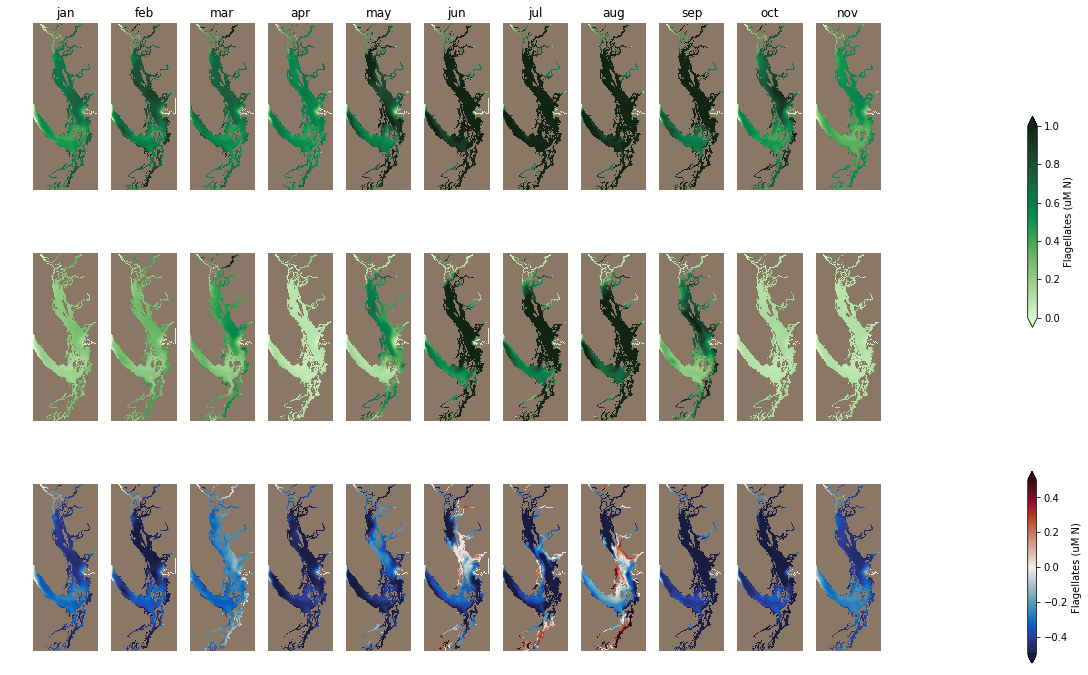

In [126]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cmap.set_bad('#8b7765')
cb1 = "Flagellates (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Flagellates (uM N)'
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

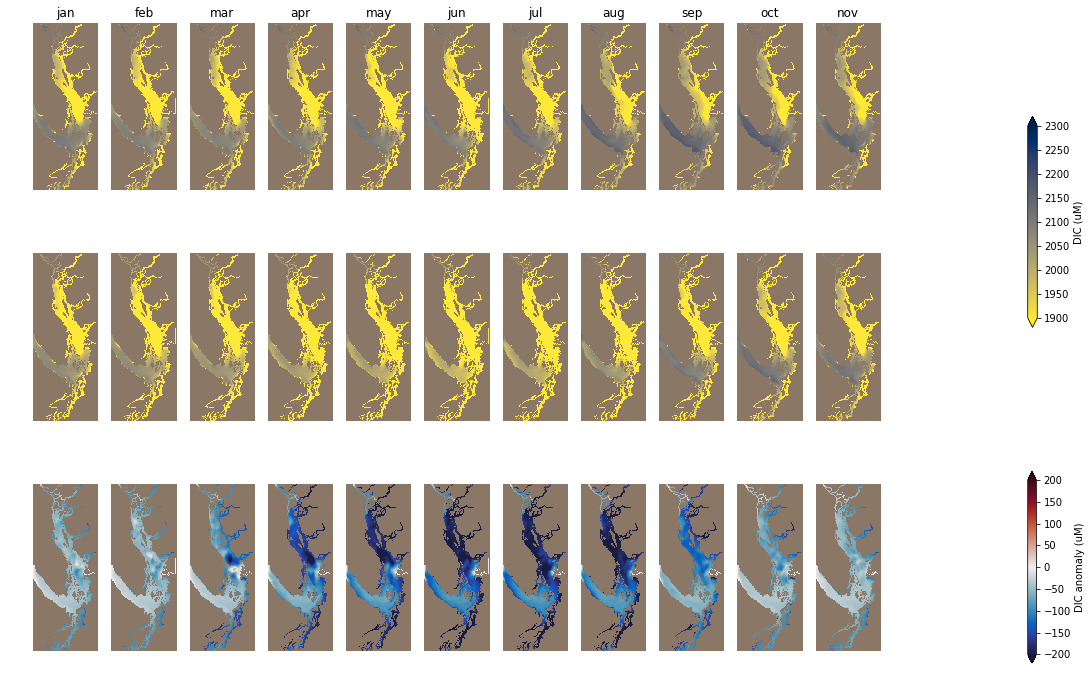

In [127]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = plt.get_cmap('cividis_r')
cmap.set_bad('#8b7765')
cb1 = 'DIC (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'DIC anomaly (uM)'
vmax = 2300
vmin = 1900
dvmax = 200
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

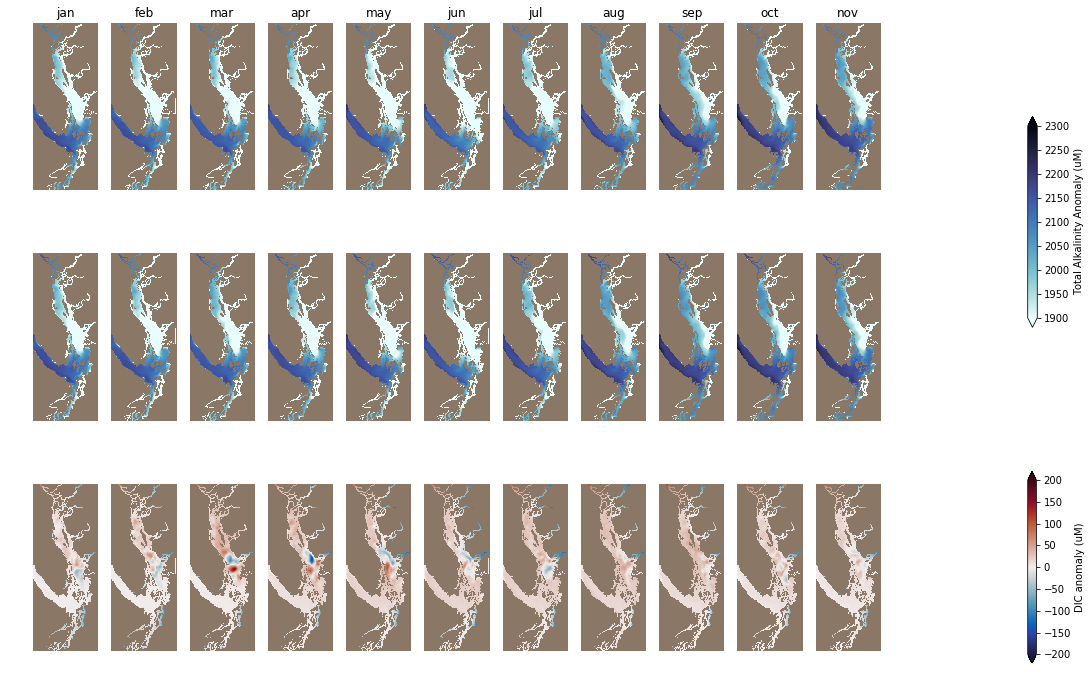

In [128]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cb1 = 'Total Alkalinity (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb1 = 'Total Alkalinity Anomaly (uM)'
vmax = 2300
vmin = 1900
dvmax = 200
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

tracer = 'Fraser_tracer'
file = 'turb'
cmap = cm.turbid
cmap.set_bad('#8b7765')
cb1 = 'Turbidity'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Turbidity'
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_compare_2015_surface.png')

# Profiles

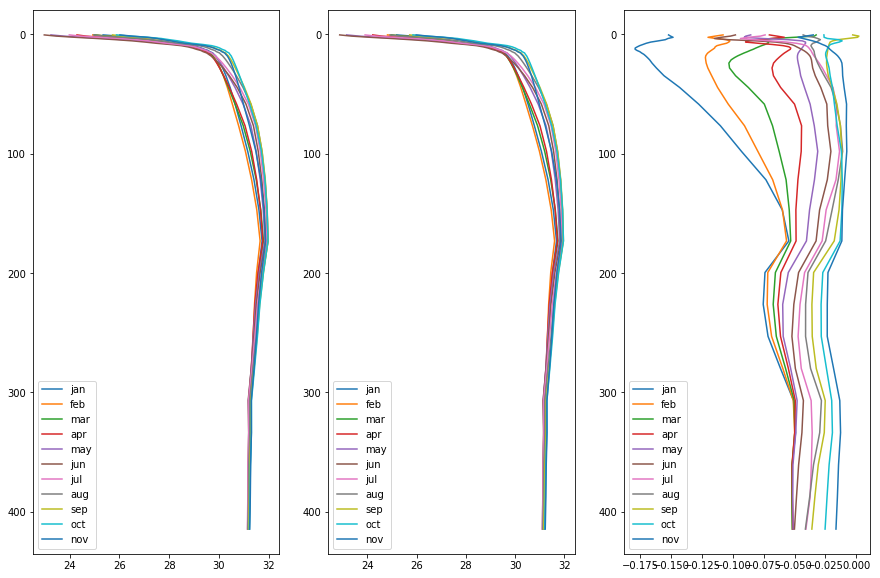

In [129]:
tracer = 'vosaline'
file = 'grid'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

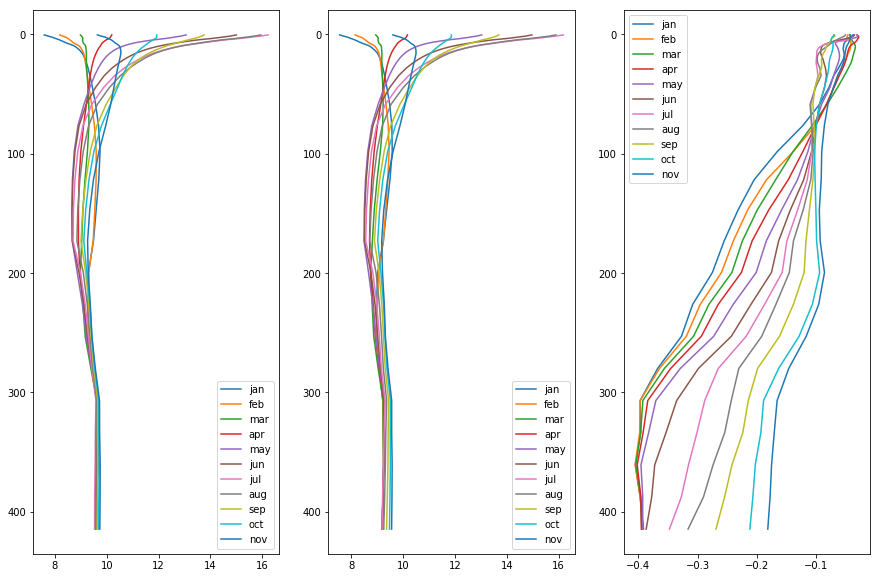

In [130]:
tracer = 'votemper'
file = 'grid'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

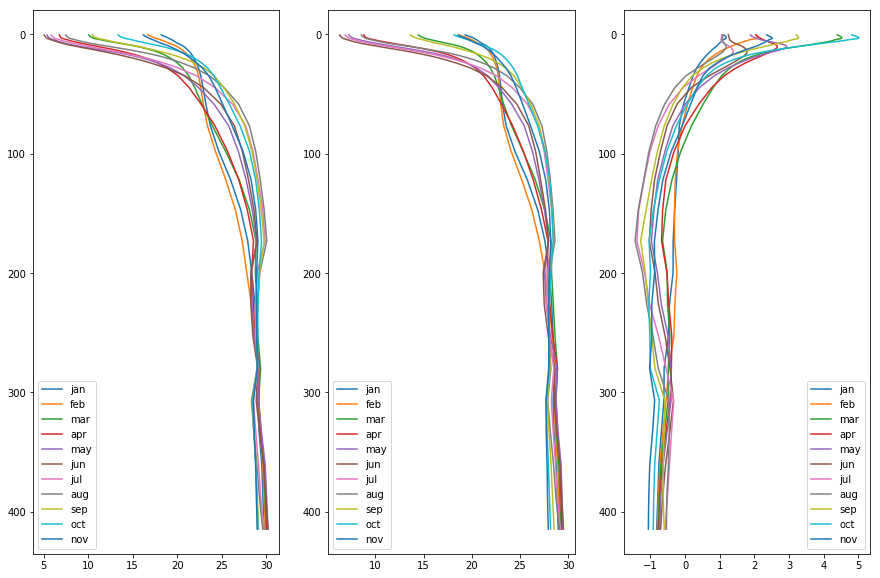

In [131]:
tracer = 'nitrate'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

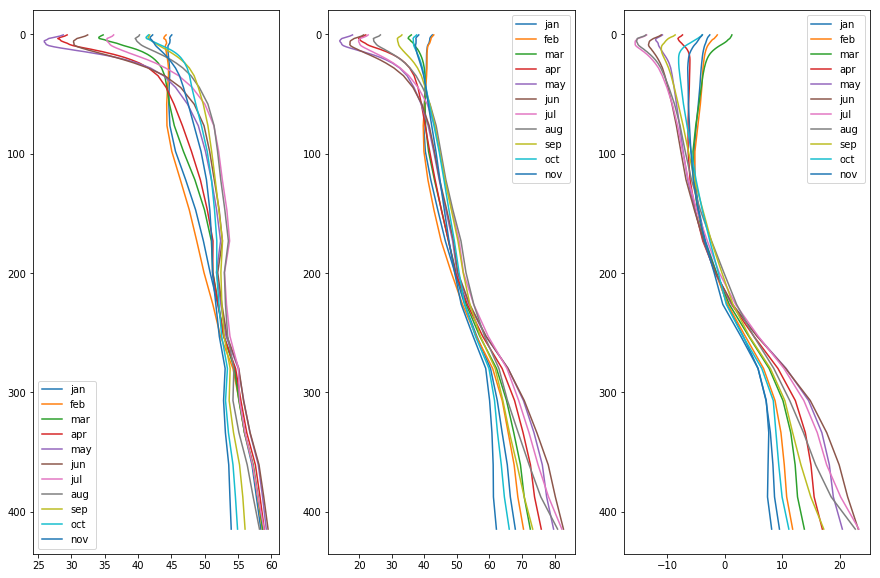

In [132]:
tracer = 'silicon'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

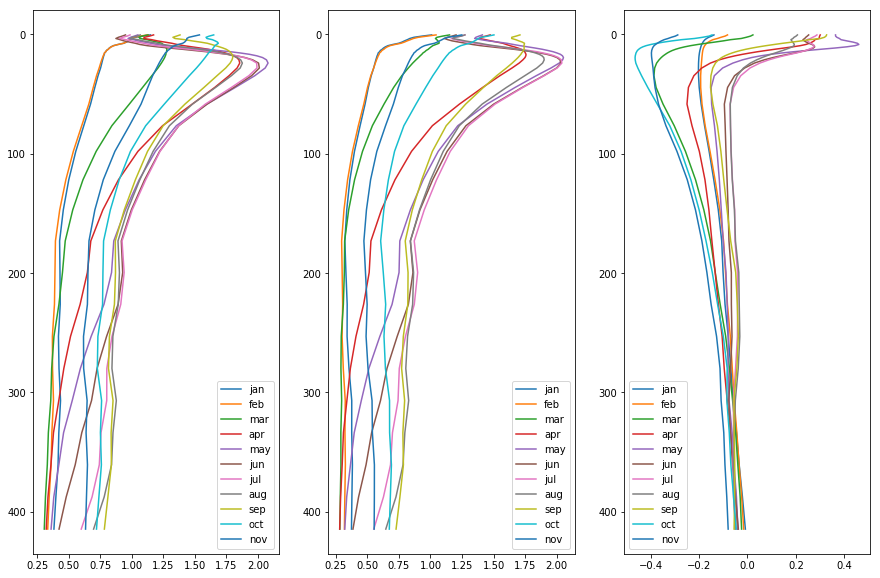

In [133]:
tracer = 'ammonium'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

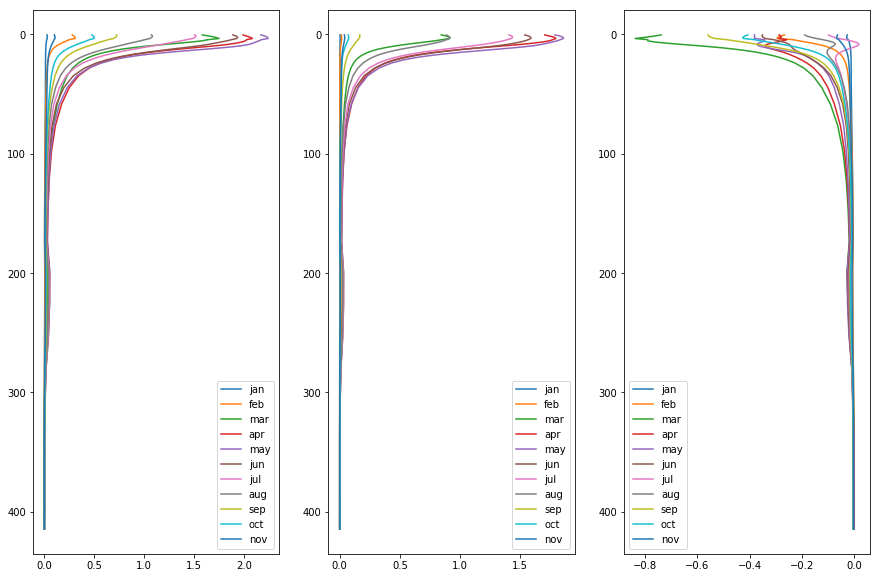

In [134]:
tracer = 'diatoms'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

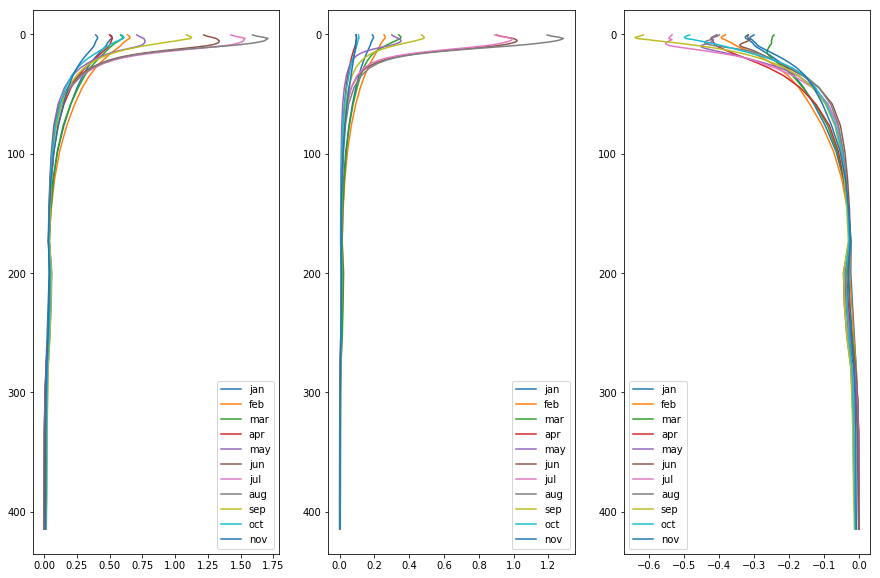

In [135]:
tracer = 'flagellates'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

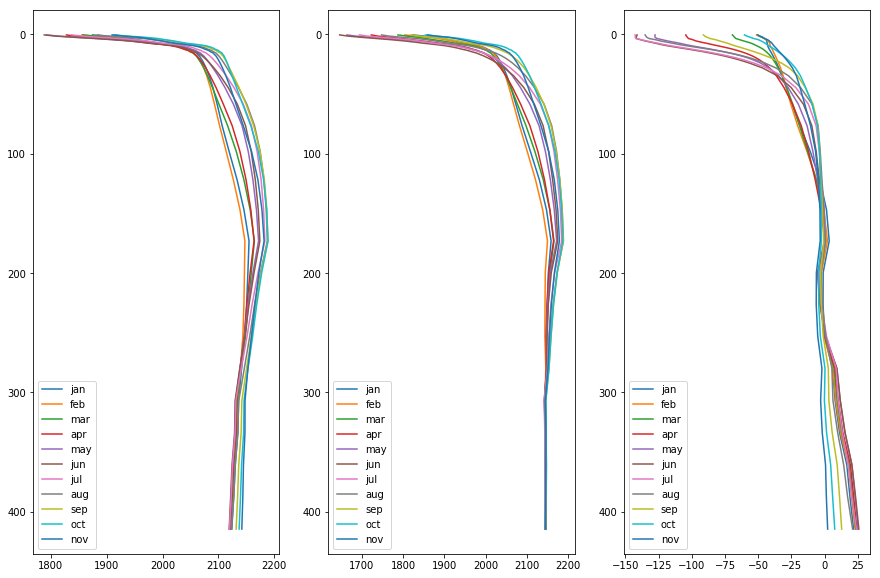

In [136]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

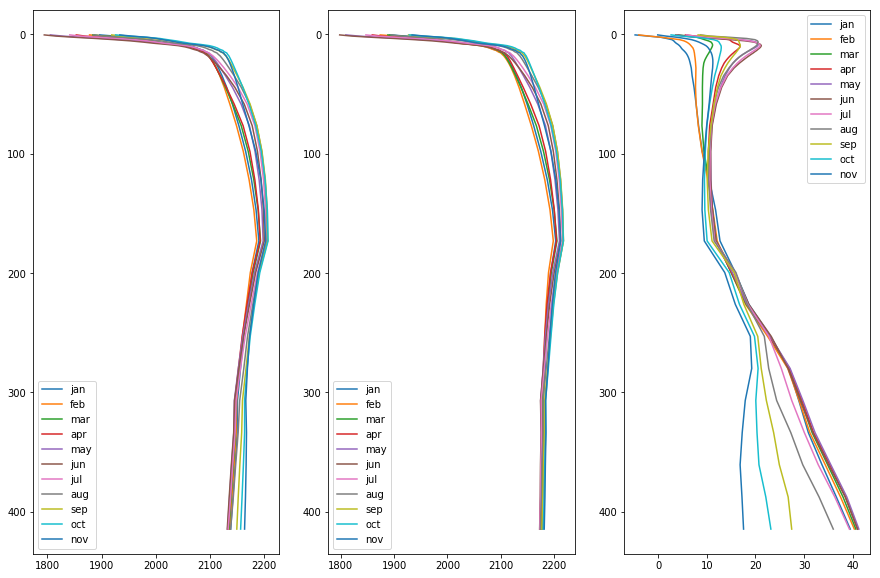

In [137]:
tracer = 'total_alkalinity'
file = 'carp'
fig = profiles(tracer, file)
fig.savefig(tracer+'_compare_2015_profiles.png')

tracer = 'Fraser_tracer'
file = 'turb'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

# Thalwegs

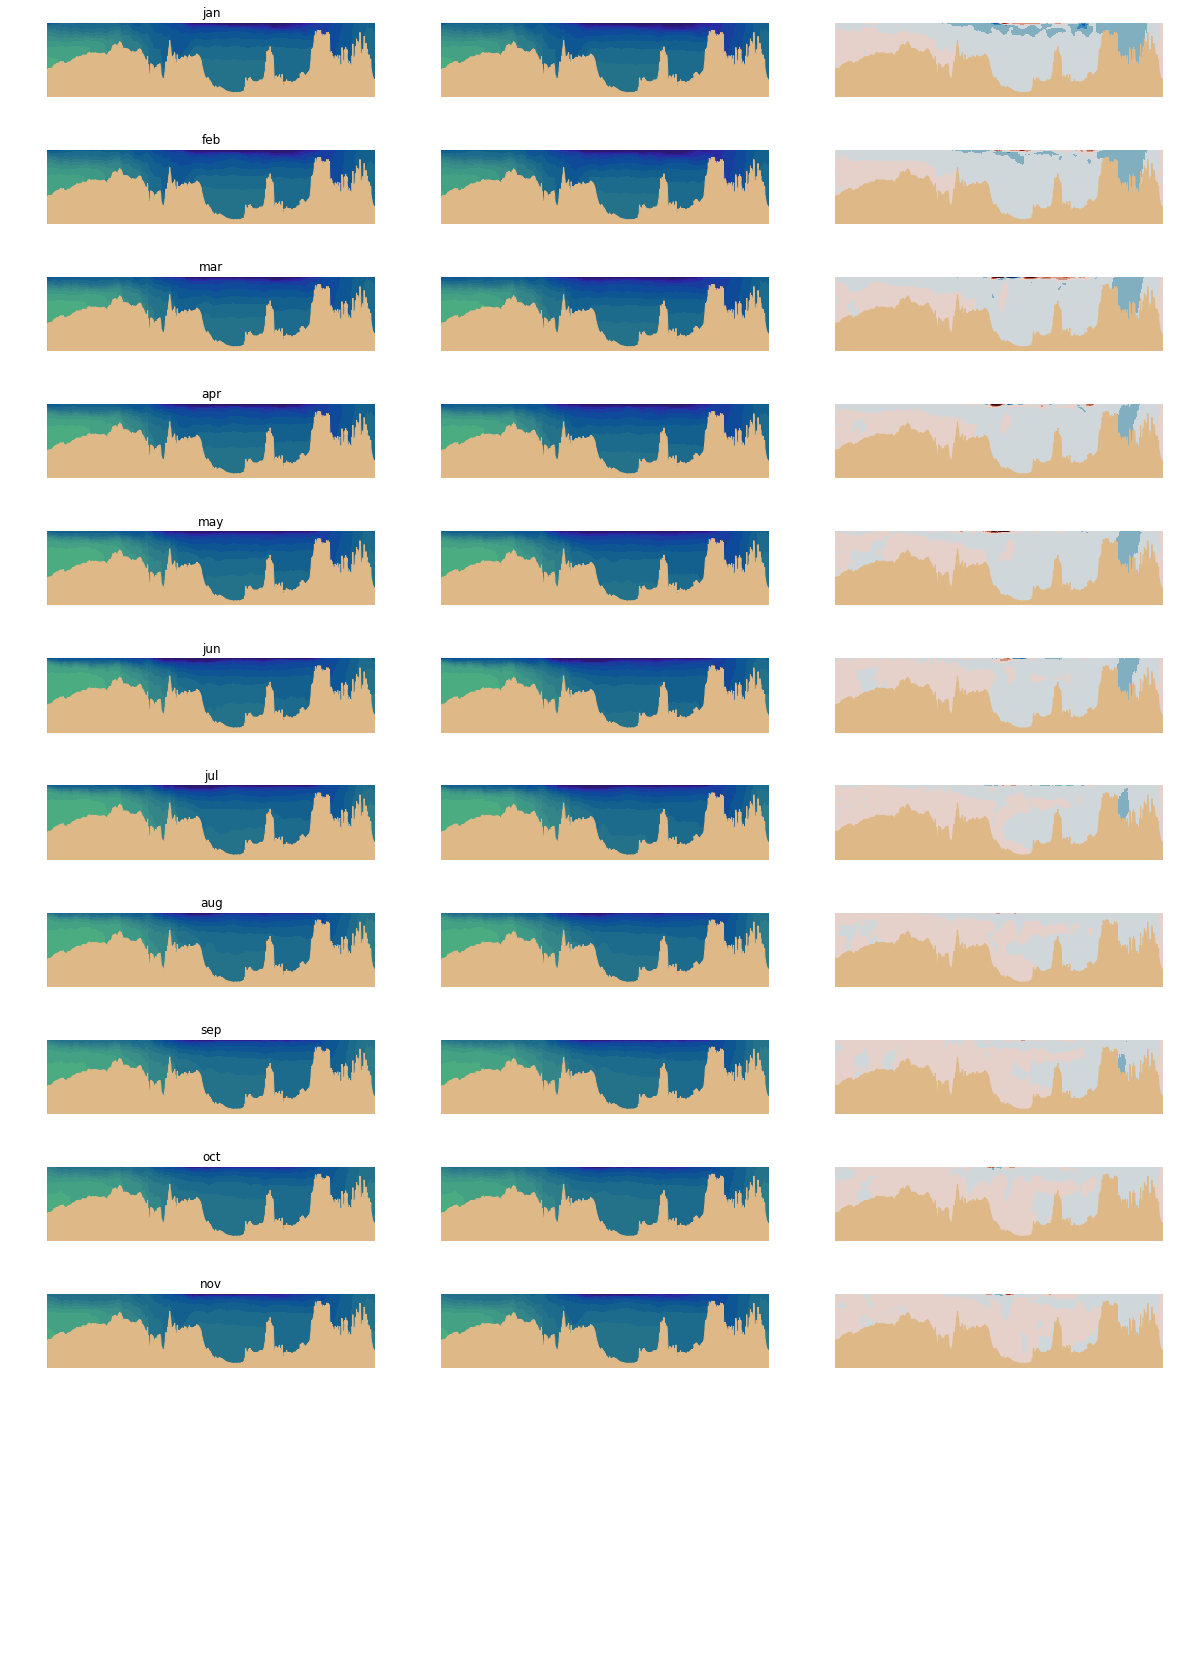

In [138]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 32.1
vmin = 28
dvmax = 0.5
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

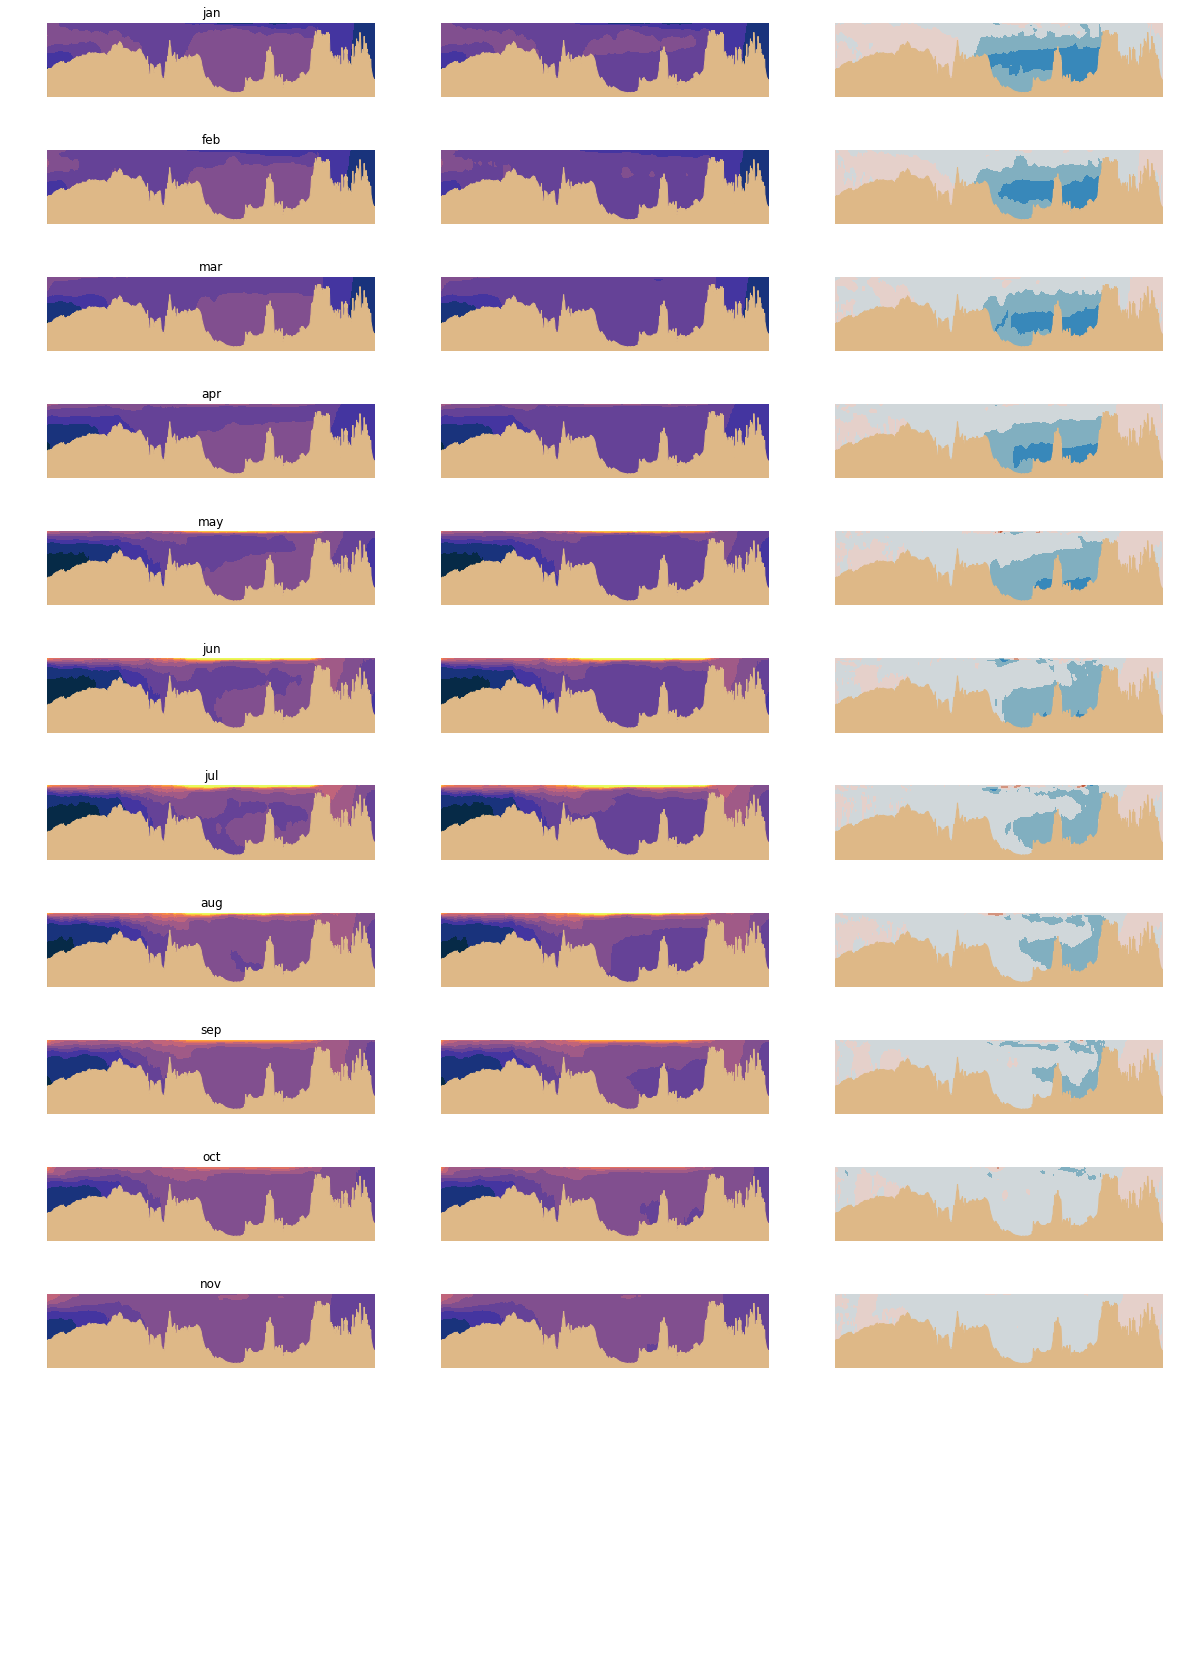

In [139]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cdiff = cm.balance
vmax = 15
vmin = 6
dvmax = 1
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

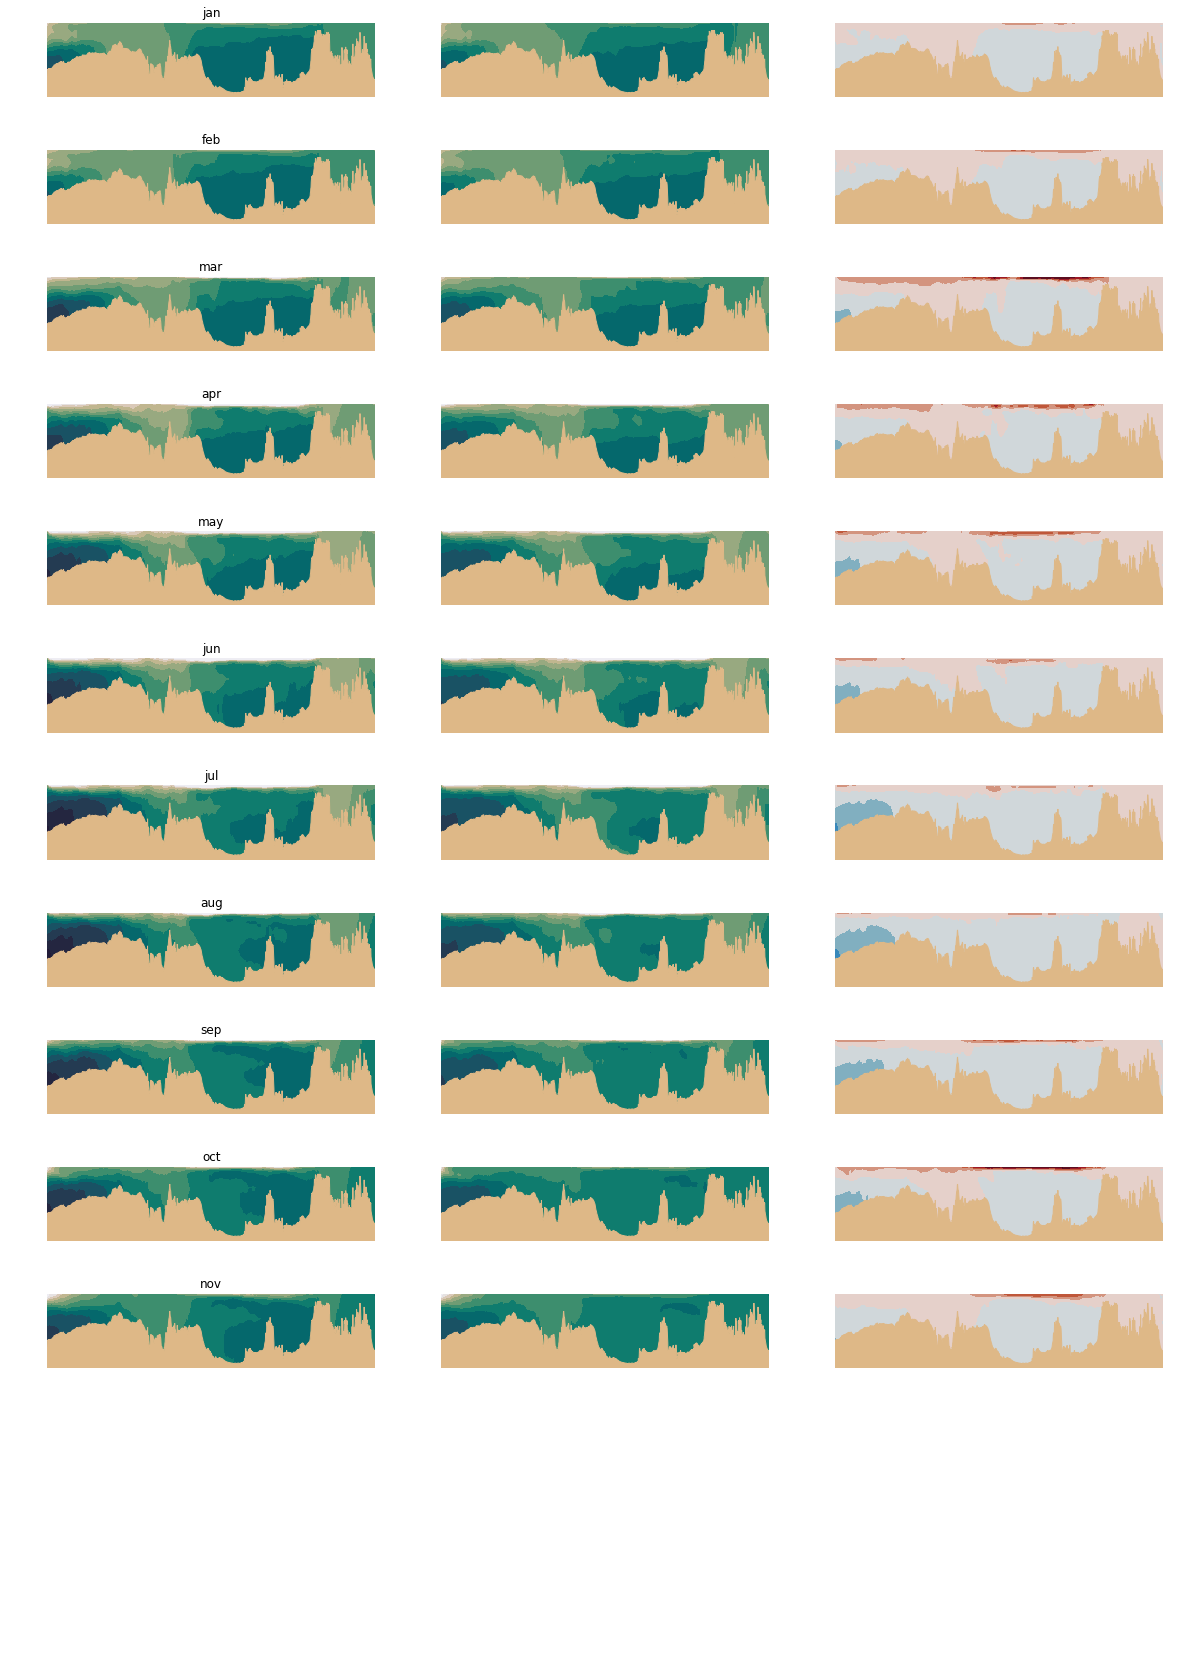

In [140]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cdiff = cm.balance
vmax = 35
vmin = 10
dvmax = 10
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

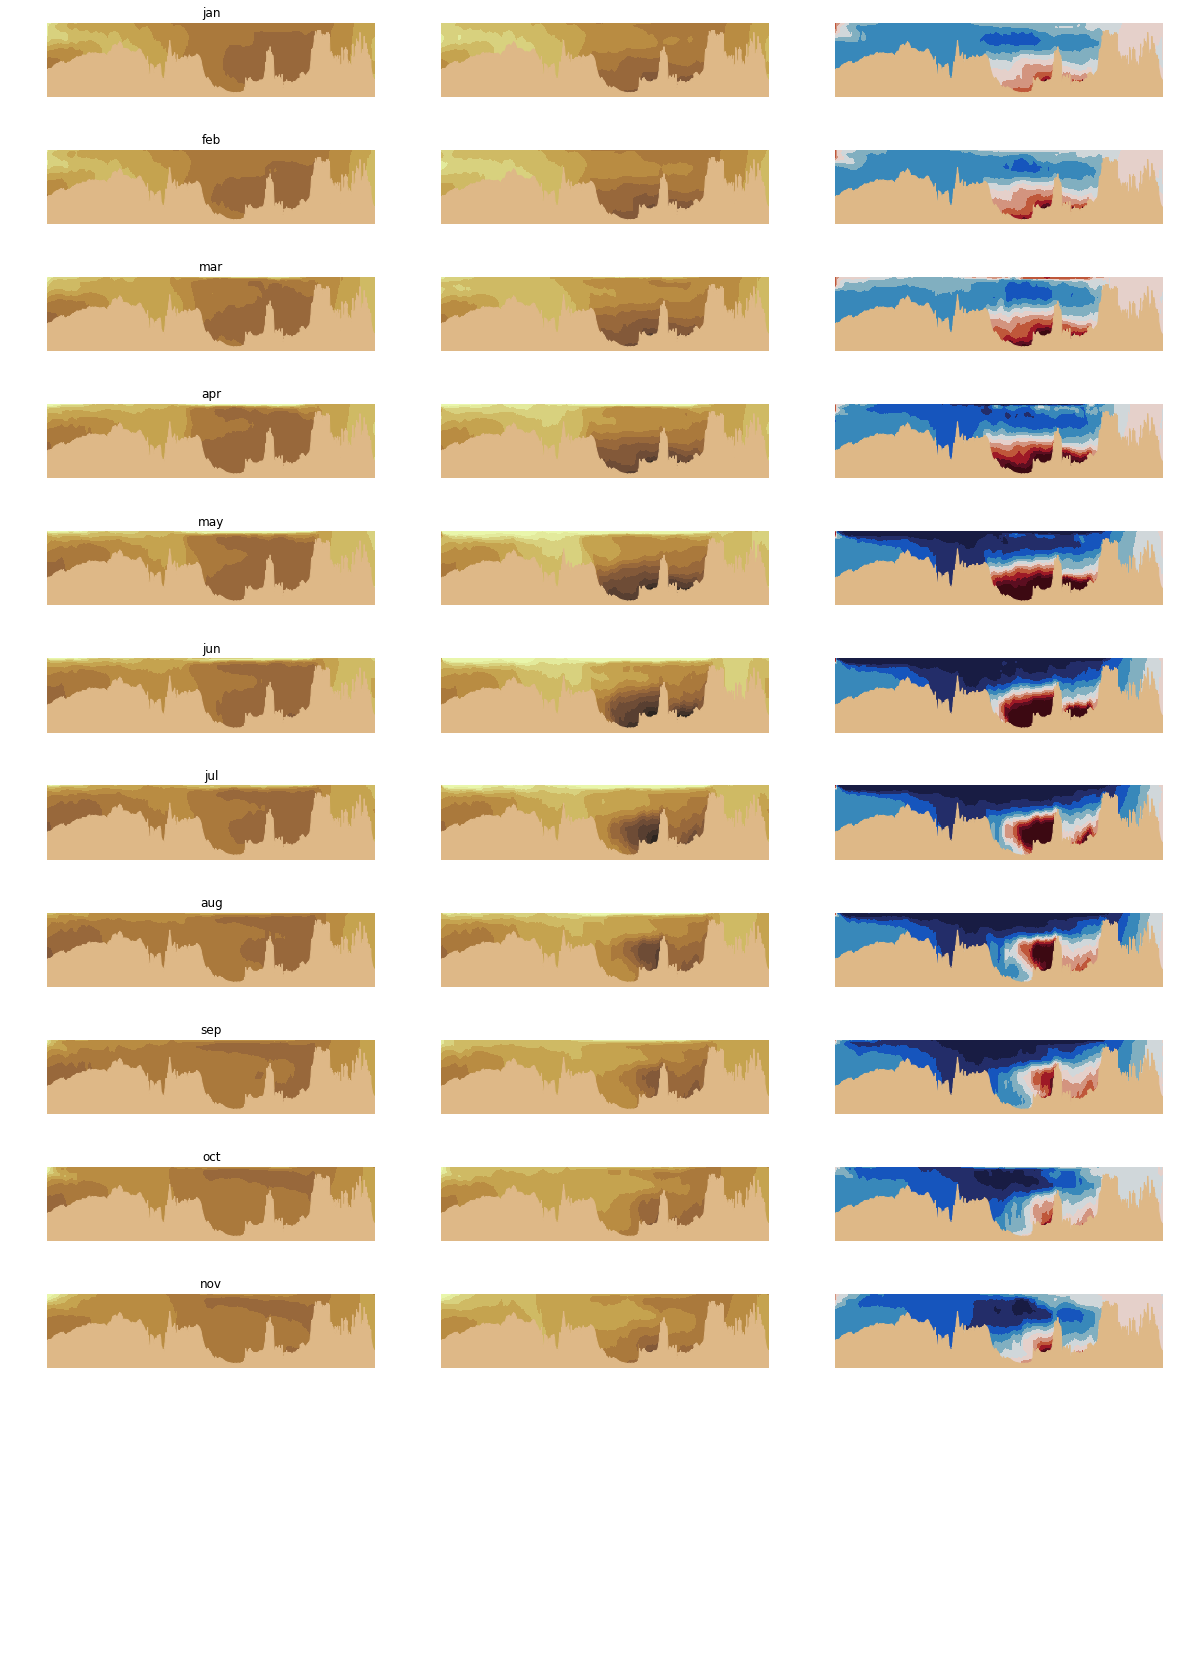

In [141]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cdiff = cm.balance
vmax = 70
vmin = 25
dvmax = 10
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

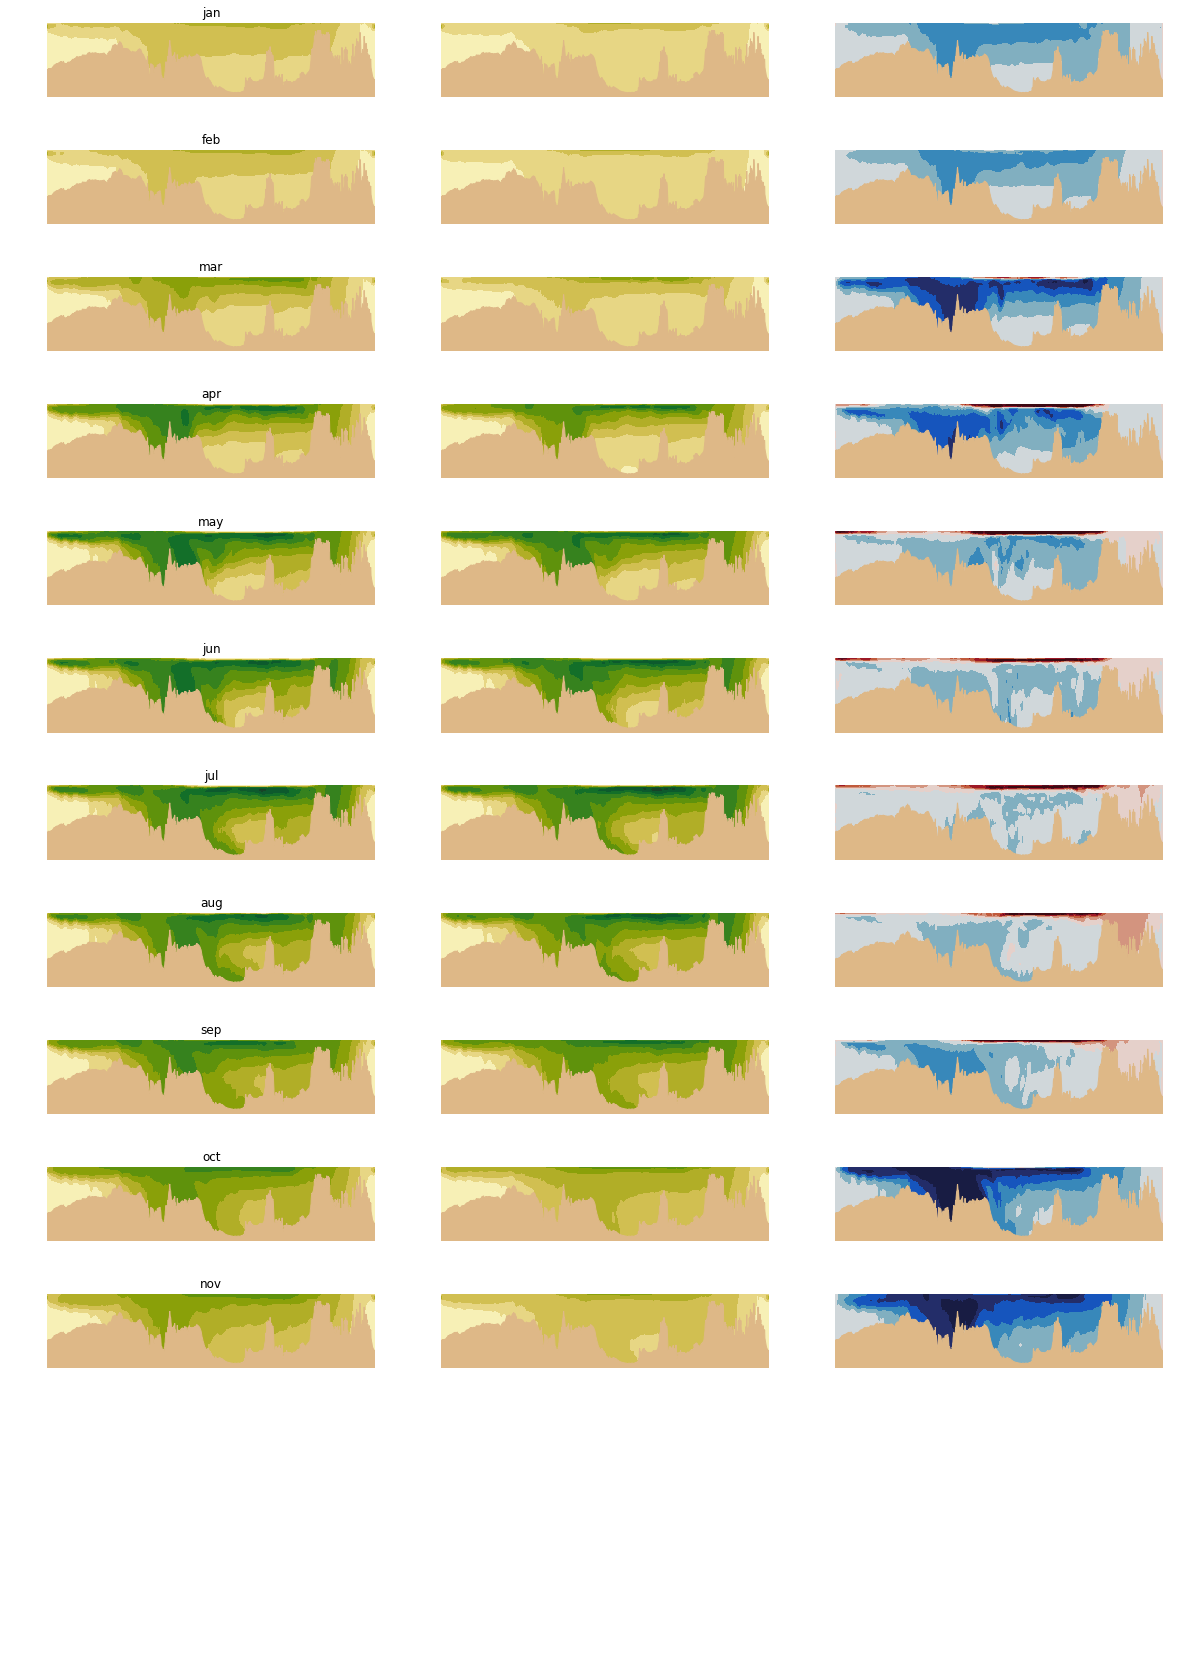

In [142]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cdiff = cm.balance
vmax = 3
vmin = 0
dvmax = 0.5
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

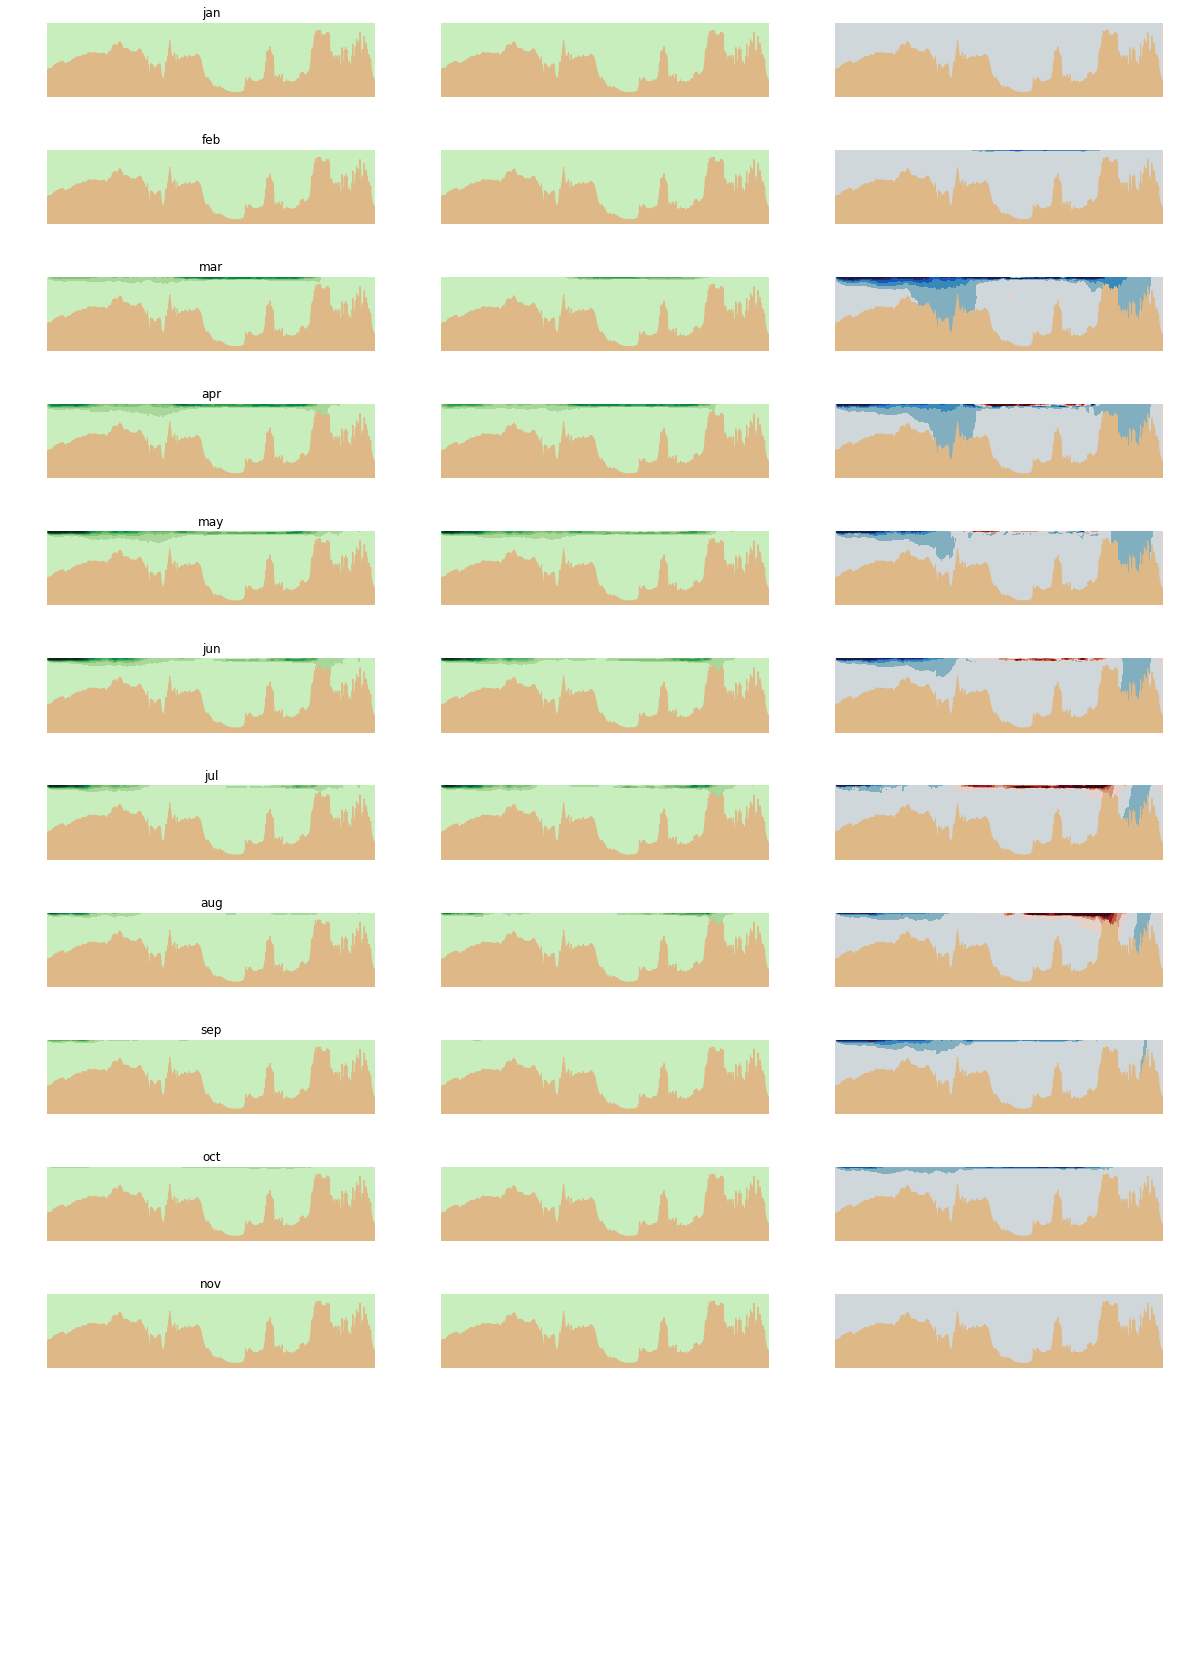

In [143]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 0.5
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

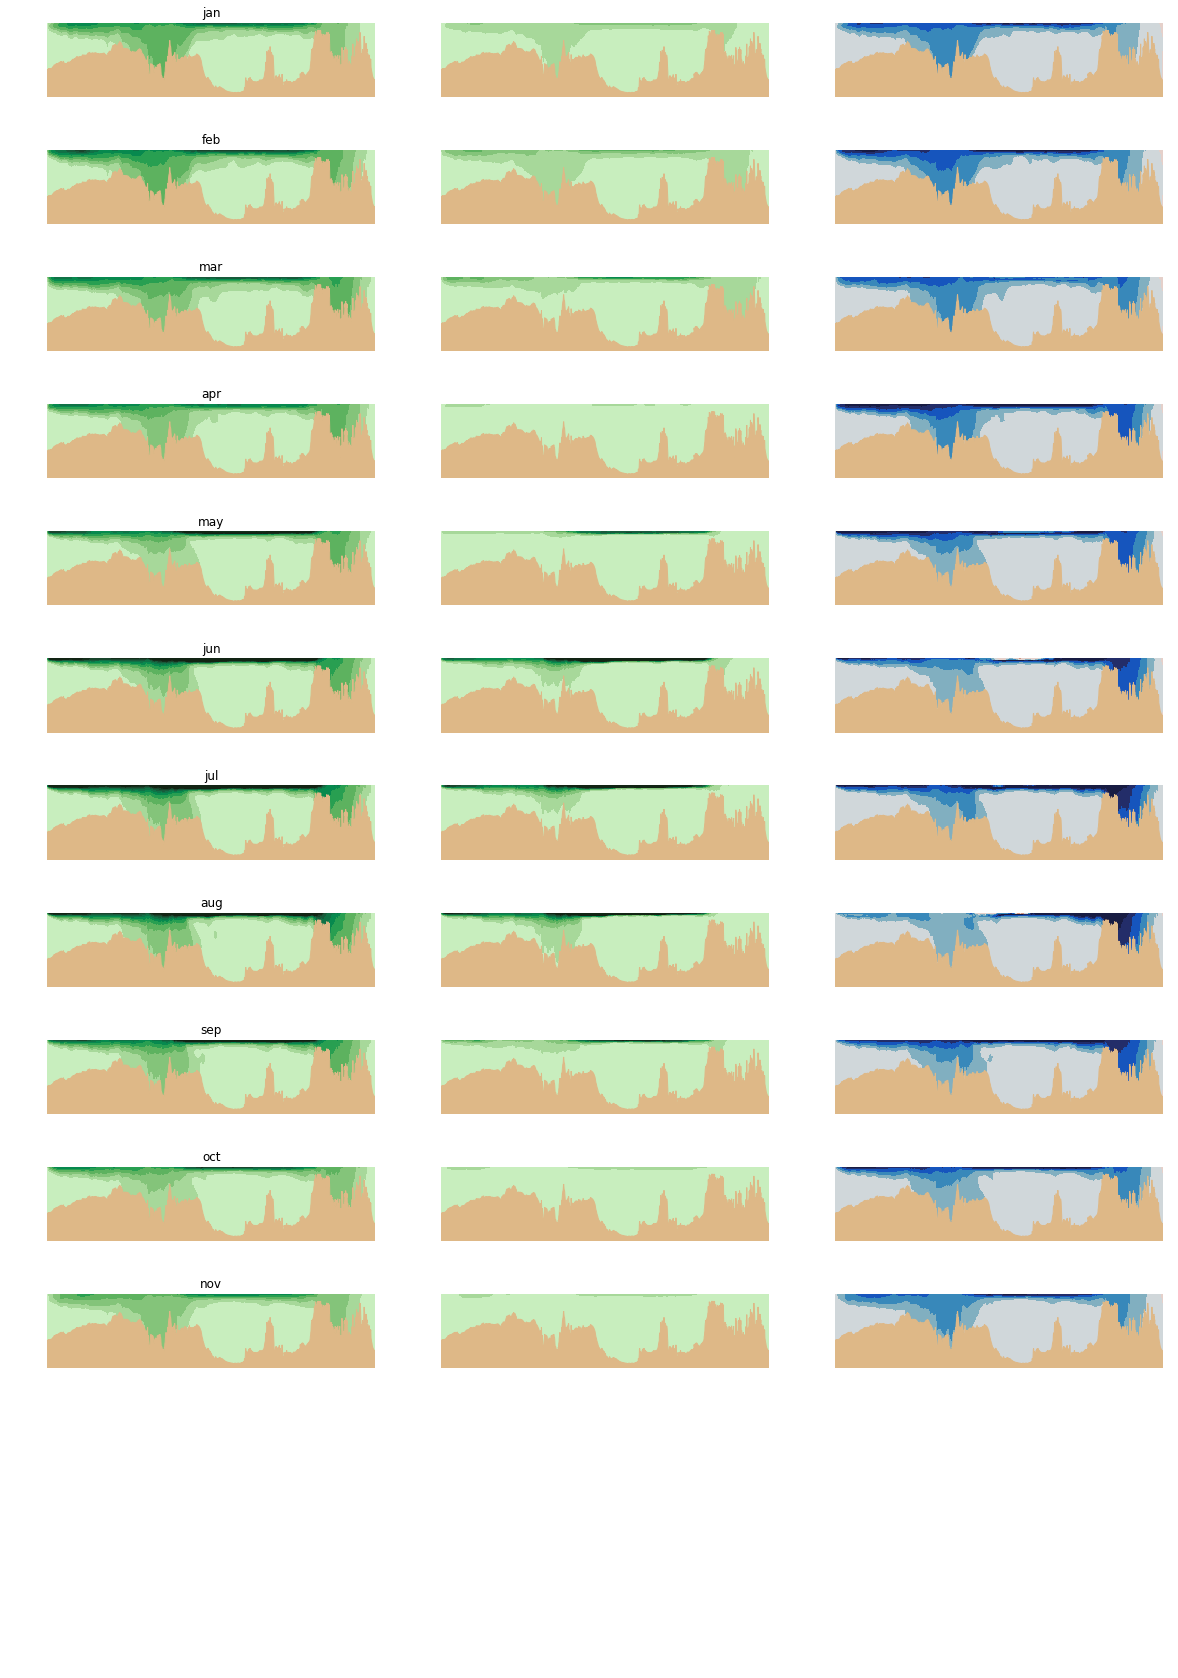

In [144]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.4
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

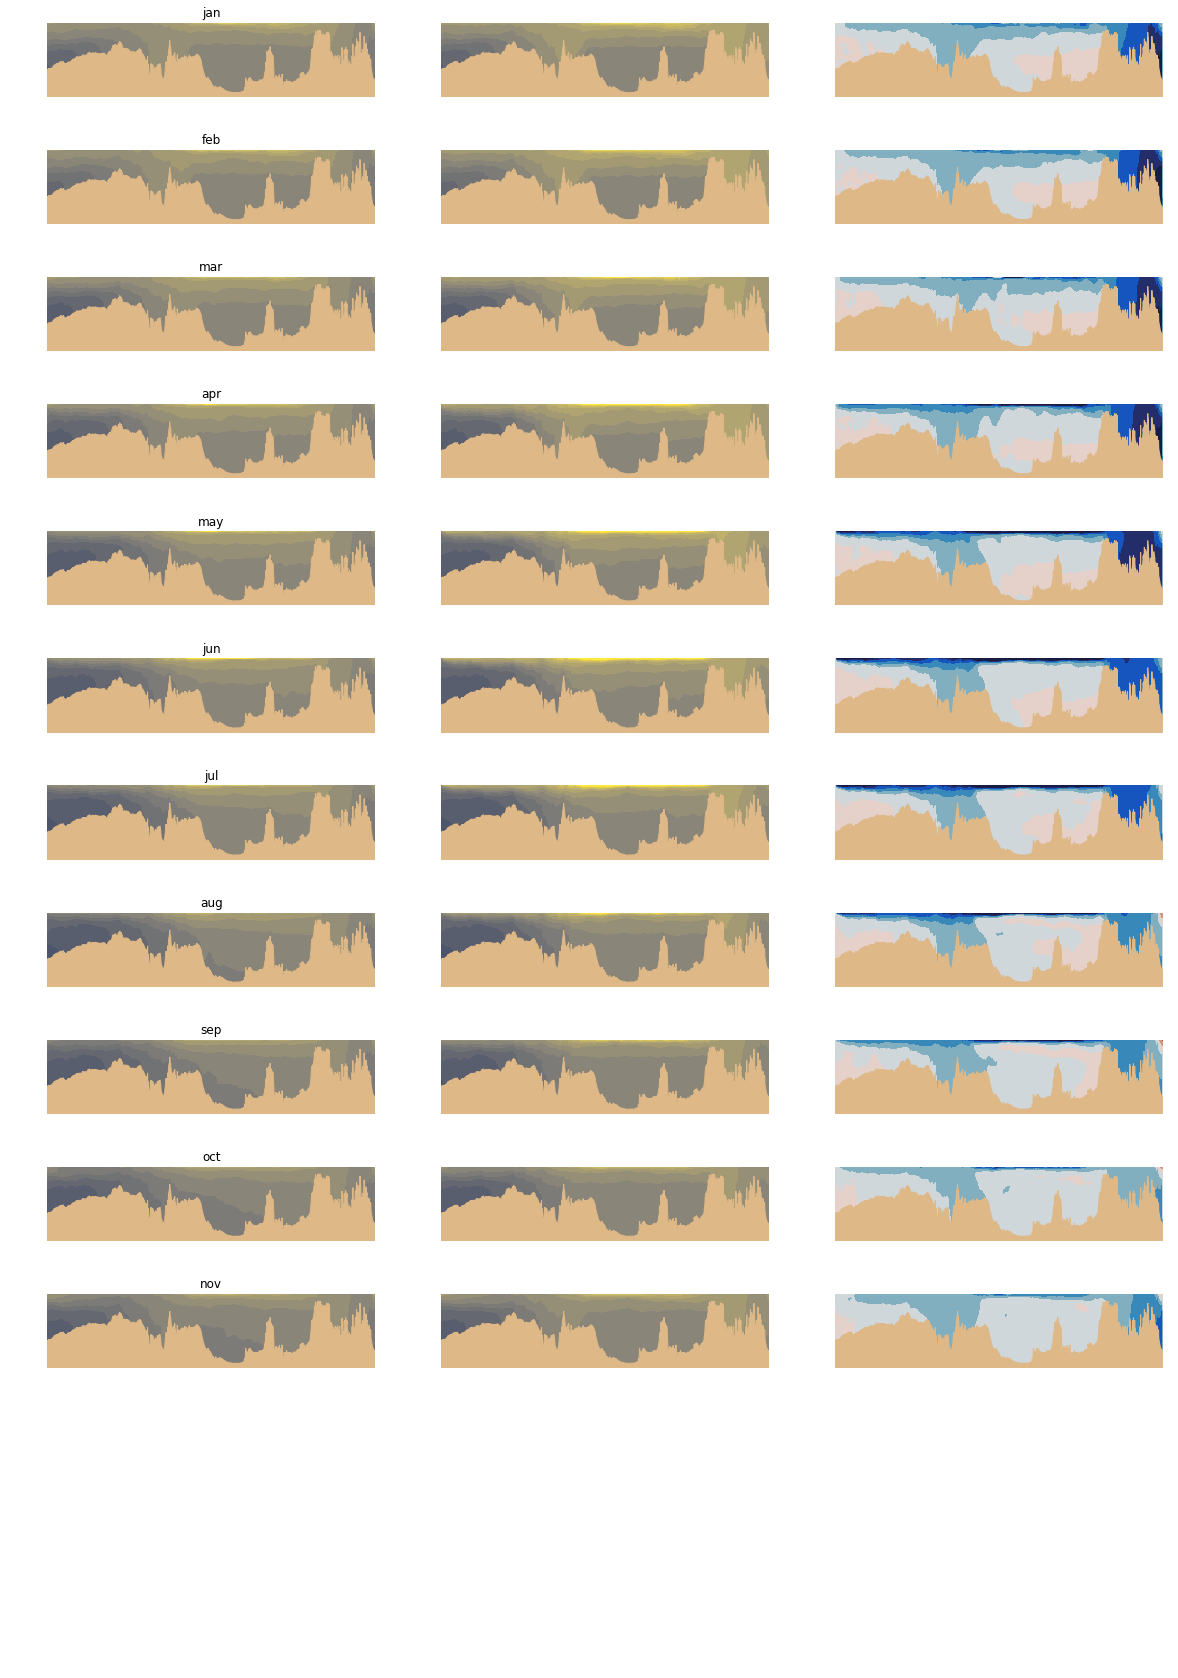

In [145]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 100
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

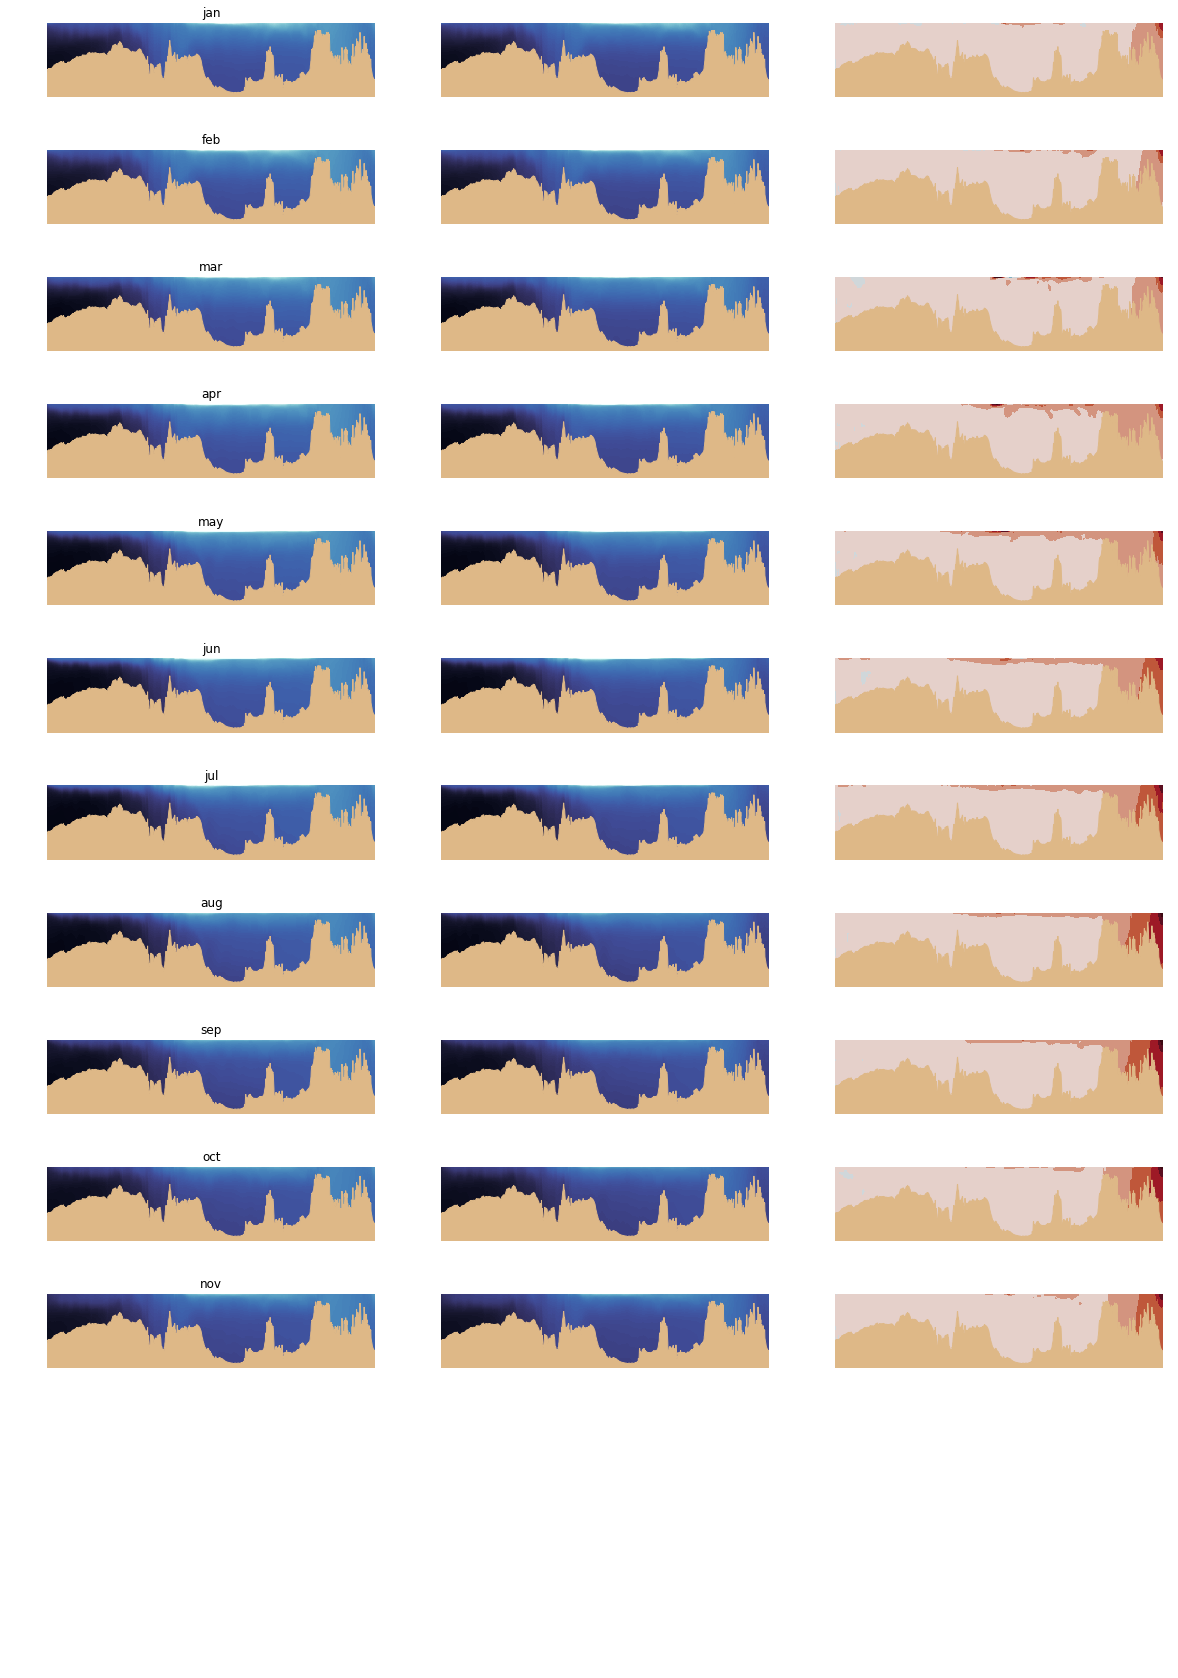

In [146]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cdiff = cm.balance
vmax = 1940
vmin = 1900
dvmax = 100
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_compare_2015_thalweg.png')

tracer = 'Fraser_tracer'
file = 'turb'
cmap = cm.turbid
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 0.2
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')